In [ ]:
# default_exp nbeats.interpret

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Interpret

> Interpret the results of a model

In [ ]:
# export
from fastseq.all import *
from fastseq.data.external import *
from fastai2.basics import *
# from fastseq.nbeats.models import *
from fastseq.nbeats.learner import *

Train:1600; Valid: 1600; Test 100


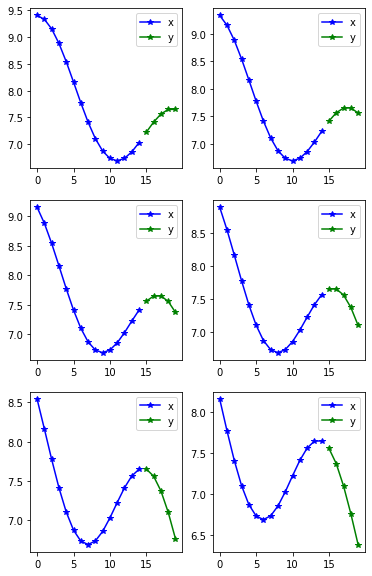

In [ ]:
items = dummy_data_generator(50, 10, nrows=100)
dbunch = TSDataLoaders.from_items(items, horizon = 5, lookback = 15)
dbunch.show_batch(max_n=6)

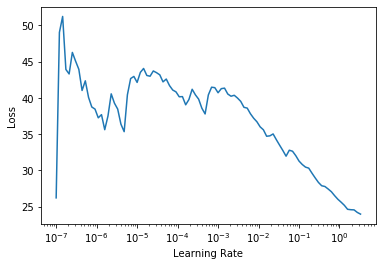

In [ ]:
learn = nbeats_learner(dbunch)
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,b_loss,theta,time
0,29.830330,16.977161,3.534777,1.240905,77.069267,0.272346,00:02
1,25.597263,12.921595,2.993141,1.017208,115.805389,0.340805,00:02
2,22.932133,10.983185,2.724478,0.905349,129.432404,0.348765,00:02
3,20.885424,9.569956,2.516996,0.812950,129.997543,0.357148,00:02
4,19.186605,8.425309,2.342046,0.741557,129.757874,0.355440,00:02
5,17.709890,7.420746,2.179345,0.676848,128.556747,0.356379,00:02
6,16.336620,6.727065,2.067367,0.619215,120.780762,0.364736,00:02
7,15.199161,5.685723,1.876330,0.560513,122.515800,0.360119,00:02
8,14.079194,5.082819,1.745421,0.502946,116.793411,0.368558,00:02
9,13.172047,4.451090,1.631845,0.487400,114.025589,0.356829,00:02


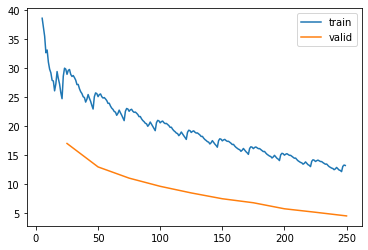

In [ ]:
learn.fit(10, 2e-3)
learn.recorder.plot_loss()

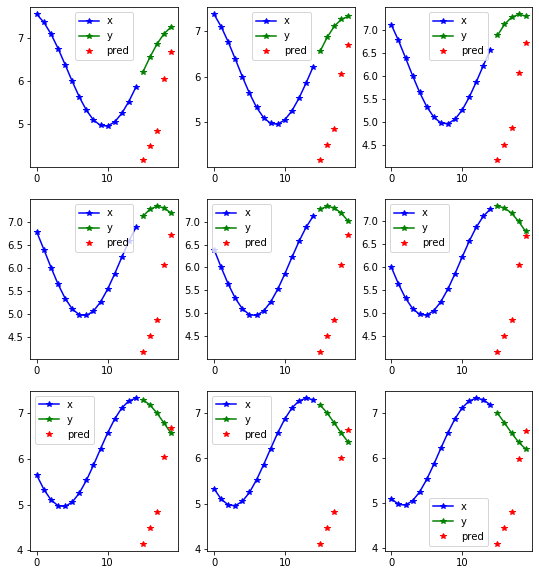

In [ ]:
learn.show_results(max_n=9)

In [ ]:
# hide
idx = tensor([419,   5, 401, 413, 418,   4, 400, 227, 533])
_ = learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)
l_dct = learn.n_beats_trainer.out
print([{block +'_'+ name:l_dct[block][name].shape for name in l_dct[block]} for block in l_dct if 'total' not in block])
{block + '_f':l_dct[block]['f'][idx,:].shape for block in l_dct if 'total' not in block} 


[{'bias0_0_b': torch.Size([13000, 48]), 'bias0_0_f': torch.Size([13000, 12]), 'bias0_0_theta': torch.Size([13000, 2])}, {'bias0_1_b': torch.Size([13000, 48]), 'bias0_1_f': torch.Size([13000, 12]), 'bias0_1_theta': torch.Size([13000, 2])}, {'bias0_2_b': torch.Size([13000, 48]), 'bias0_2_f': torch.Size([13000, 12]), 'bias0_2_theta': torch.Size([13000, 2])}, {'trend1_0_b': torch.Size([13000, 48]), 'trend1_0_f': torch.Size([13000, 12]), 'trend1_0_theta': torch.Size([13000, 3])}, {'trend1_1_b': torch.Size([13000, 48]), 'trend1_1_f': torch.Size([13000, 12]), 'trend1_1_theta': torch.Size([13000, 3])}, {'trend1_2_b': torch.Size([13000, 48]), 'trend1_2_f': torch.Size([13000, 12]), 'trend1_2_theta': torch.Size([13000, 3])}, {'seaonality2_0_b': torch.Size([13000, 48]), 'seaonality2_0_f': torch.Size([13000, 12]), 'seaonality2_0_theta': torch.Size([13000, 3])}, {'seaonality2_1_b': torch.Size([13000, 48]), 'seaonality2_1_f': torch.Size([13000, 12]), 'seaonality2_1_theta': torch.Size([13000, 3])}, {'

{'bias0_0_f': torch.Size([9, 12]),
 'bias0_1_f': torch.Size([9, 12]),
 'bias0_2_f': torch.Size([9, 12]),
 'trend1_0_f': torch.Size([9, 12]),
 'trend1_1_f': torch.Size([9, 12]),
 'trend1_2_f': torch.Size([9, 12]),
 'seaonality2_0_f': torch.Size([9, 12]),
 'seaonality2_1_f': torch.Size([9, 12]),
 'seaonality2_2_f': torch.Size([9, 12])}

In [ ]:
# export
class NBeatsInterpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses, dct = None):
        store_attr(self, "dl,inputs,preds,targs,decoded,losses,dct")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dbunch.dls[ds_idx]
        res = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
        dct = learn.n_beats_trainer.out        
        return cls(dl, *res, dct=dct)

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    
    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        total_b = self.dct.pop('total_b')[idx, :]
        backwards = {block+'_b':self.dct[block]['b'][idx,:] for block in self.dct} 
        forwards = {block+'_f':self.dct[block]['f'][idx,:] for block in self.dct}  
        
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses, b=backwards, f=forwards, total_b=total_b, **kwargs)
#         #TODO: figure out if this is needed
#         #its None means that a batch knos how to show itself as a whole, so we pass x, x1
#         else: 
#         show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
# export 
def add_stack(b):
    res = {}
    for stack in set([o[:-4] for o in b.keys()]):
        for direction in ['f','b']:
            for key in b.keys():
                if stack in key and direction == key[-1]:
                    if stack+'_'+direction in res:
                        res[stack+'_'+direction] += b[key]
                    else:
                        res[stack+'_'+direction] = b[key]
    return res
            
    

In [ ]:
dct = {'bias0_0_f':torch.ones(1,1), 'bias0_1_f': torch.ones(1,1), 'bias0_2_f': torch.ones(1,1),'bias0_1_b': torch.ones(1,1)*10,
       'trend1_0_f': torch.ones(1,1)*100, 'trend1_1_f':torch.ones(1,1)*100}
res = add_stack(dct)
test_eq(res,{'trend1_f': tensor([[200.]]), 'bias0_f': tensor([[3.]]), 'bias0_b': tensor([[10.]])})

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TSTensorSeq, y:TSTensorSeqy, *args, b={}, f={}, total_b=None, combine_stack=True,
                    rows=None, cols=None, figsize=None, **kwargs):
    
    figsize = (2*3, x.shape[0]*3+0) if figsize is None else figsize
    _, axs = plt.subplots(x.shape[0], 2, figsize=figsize, sharey='row')
    axs = axs.flatten()
    normal = np.arange(0,x.shape[0]*2,2)
    if combine_stack:
        b = add_stack(b)
        f = add_stack(f)
    for i, (_x, _y, pred, t) in enumerate(zip(x, y, args[2], args[3])):
        ax = axs[i*2]
        ctx = show_graph(_x, ax=ax, title=str(t.data))
        a = [TSTensorSeqy(_y, x_len = x.shape[-1], m = '-g'), TSTensorSeqy(pred,x_len = x.shape[-1], m = '-*r')]
        if 'total_b' is not None:
            ctx = TSTensorSeqy(-total_b[i,:], m = '-*r',label='y_backwards').show(ctx=ctx)            
        for y in a:
            ctx = y.show(ctx=ctx)
        ax = axs[i*2 + 1]
        total = torch.zeros_like(b[list(b.keys())[0]][i,:])
        for k_f, k_b, c in zip(f.keys(),b.keys(), ['y','k','g','r','b','b','b','b']):
            ax = TSTensorSeqy(f[k_f][i,:],x_len = x.shape[-1], m = '-*'+c, label = k_f).show(ctx=ax)
            ax = TSTensorSeqy(b[k_b][i,:], m = '-*'+c, label= k_b).show(ctx=ax)
            total += b[k_b][i,:]
        
#         ax = TSTensorSeqy(total, m = '-*y', label= 'tot').show(ctx=axs[i*2])
        ax.legend(bbox_to_anchor=(1.3, 1.05))
            
    

In [ ]:
from fastai2.interpret import *

In [ ]:
interp = NBeatsInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

KeyError: 'total_b'

TODO: second run plot_top_loss will not work because of :
`total_b = self.dct.pop('total_b')[idx, :]`

In [ ]:
learn.n_beats_trainer.theta_means()

{'bias0_0': tensor([-0.0809, -0.8732], device='cuda:0'), 'bias0_1': tensor([ 0.0403, -0.0730], device='cuda:0'), 'bias0_2': tensor([0.0029, 0.0508], device='cuda:0'), 'trend1_0': tensor([-0.0070, -0.0105, -0.0359], device='cuda:0'), 'trend1_1': tensor([ 0.0013,  0.0026, -0.0022], device='cuda:0'), 'trend1_2': tensor([ 0.0137, -0.0043,  0.0120], device='cuda:0'), 'seaonality2_0': tensor([ 0.2450,  0.2490, -0.2305], device='cuda:0'), 'seaonality2_1': tensor([-0.3496,  0.3552, -0.2069], device='cuda:0'), 'seaonality2_2': tensor([ 0.0459, -0.2137, -0.1004], device='cuda:0')}


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
